# Cluster tracking for optical flow estimation
Find the attribution of points from frame 1 and frame 2. There are four scenarios:

- Move
- Merge
- Split
- Appear
- Die out

Objective function for minmization:

    the sum of squared errors for the shift (short movements are preferred)
    
    the squared difference of weight between shifted/merged clusters (good predictive power)
    
    a punishing term for each cluster center that dies (based on it's size)
    
    a punishing term for each cluster center that appears (based on it's size)

For efficient computation we initialize using the following heuristic:

In [13]:
from scipy.optimize import minimize

In [15]:
def energy_conversation(map_arr):
    return 0

def spacial_stationary(map_arr, coords, no_match_punishment = 100):
    error = 0
    for source, target in enumerate(map_arr):
        if source == 0:
            continue
        #print("from " + str(source) + " to " + str(target))
        if target == 0.0:
            error += no_match_punishment
            continue
        if int(target) >= len(coords[0]) or int(target) >= len(coords[1]) or int(target)<0:
            error += no_match_punishment
            continue
        source_location = coords[0][int(source)]
        target_location = coords[1][int(target)]
        distance = np.sqrt(np.square(source_location[0]-target_location[0])+np.square(source_location[1]-target_location[1]))
        error += distance
    return error

def combined_objective(map_arr, coords):
    e = energy_conversation(map_arr)
    s = spacial_stationary(map_arr, coords)
    combined = e + s
    return combined

def dict_to_lists(mapping):
    length = np.max(list(mapping.keys()))+1
    map_arr = np.zeros(length)
    for k,v in mapping.items():
        map_arr[k] = v
    return np.array(map_arr,dtype=np.int32)

map_arr = dict_to_lists(mapp[0])
spacial_stationary(map_arr, [coords[0],coords[1]])
res = minimize(combined_objective,dict_to_lists(mapp[0]),[coords[0],coords[1]], method="Nelder-Mead")
np.array(res["x"], dtype=np.int32)==dict_to_lists(mapp[0])

NameError: name 'mapp' is not defined

In [1]:
import copy

In [1]:
import numpy as np
import scipy.stats as st

class FastDensityClustering():
    @staticmethod
    def gaussian_kernel(size=21, nsig=3):
        """Returns a 2D Gaussian kernel.
        Args:
            size: The size of the kernel (size x size)
            nsig: Sigma of the gaussian
        """
        x = np.linspace(-nsig, nsig, size+1)
        kern1d = np.diff(st.norm.cdf(x))
        kern2d = np.outer(kern1d, kern1d)
        return kern2d/kern2d.sum()

    @staticmethod
    def density_from_coordinates(coords, shape = [200,200]):
        coords[0] = coords[0]-np.min(coords[0])
        coords[1] = coords[1]-np.min(coords[1])
        coords[0] = coords[0]/np.max(coords[0])
        coords[1] = coords[1]/np.max(coords[1])
        density = np.zeros(shape=shape)
        for y,x in zip(coords[0],coords[1]):
            y*= shape[0]
            x*= shape[1]

            y = int(y)
            x = int(x)

            density[y-1,x-1] += 1
        return density

    @staticmethod
    def kernel(size, ktype):
        """ Returns a kernel of specified size and type
        Args:
            size: Kernel size
            ktype: Type of kernel. Either uniform gaussian or disk are provided.
        """
        if ktype == "uniform":
            return np.ones((size,size))
        elif ktype == "gaussian":
            k = FastDensityClustering.gaussian_kernel(size=size)
            k /= np.max(k)
            return k
        elif ktype == "disk":
            k = FastDensityClustering.gaussian_kernel(size=size)
            k /= np.max(k)
            return k > 0.03

    @staticmethod
    def collapse_iteration(arr,kernel, labels=None):
        """ Determins center of gravity for each non-zero (forground pixel) and it's surround weighted by the kernel
            and increases mass at named target position/pixel by the mass of the source pixel.
        Args:
            arr: Grayscale array of positive values where value zero stands for the background and positive values denote the mass for a given foreground pixel.
            kernel: Kernel used to weight the influance of nearby pixels in computing the center of mass
        """
        kernel_width = kernel.shape[0]
        kernel_height = kernel.shape[1]
        ys, xs = np.where(arr>0)
        new = np.zeros(arr.shape)
        abs_shift = 0

        for y, x in zip(ys,xs):
            snippet = arr[y-kernel_width//2:(y+kernel_width//2)+1, x-kernel_width//2:(x+kernel_width//2)+1]

            snippet = kernel * snippet
            weights_x = np.mean(snippet,axis=0)
            weights_y = np.mean(snippet,axis=1)

            shift_x = np.average(np.arange(kernel_width),weights=weights_x)#The inner mean returns x values, the outer is their mean -> shift x
            shift_y = np.average(np.arange(kernel_height),weights=weights_y)#The inner mean returns y values, the outer is their mean -> shift y
            shift_x -= (kernel_width-1)/2
            shift_y -= (kernel_height-1)/2


            y1 = int(y+shift_y)
            x1 = int(x+shift_x)

            abs_shift += np.abs(shift_x) + np.abs(shift_y)
            new[y1,x1] += arr[y,x]
            if type(labels) != type(None):
                if y1 != y or x1 != x:
                    new_list = []
                    new_list.extend(labels[y1,x1])
                    new_list.extend(labels[y,x])

                    labels[y1,x1] = new_list
                    labels[y,x] = []


        return new, abs_shift/len(xs), labels

    @staticmethod
    def collapse(arr, iterations = None,gravity_type="uniform", gravity_size=5, labels=True):
        """ Performs clustering by iteratively moving all mass densities (non-zero/foreground pixels) to their center of mass.
        If no value for iterations is specified the algorithm runs until convergence is achieved and the movement is marginally.
        Args:
            arr: Array of positive gray values
            iterations: Number of iterations. If no value for iterations is specified the algorithm runs until convergence is achieved.
            gravity_type: Either "uniform", "gaussian" or "disk". The contributions to the center of mass for one pixels by its surround are weighted accordingly.
            gravity_size: The size of the gravity kernel and the neighborhood used to compute the center of gravity.
        Returns:
            preliminary_cluster_centers: Array representation of the preliminary cluster centers. The array has the same shape as the input arr.
                                         Each cluster center is represented by a non-zero pixel. The value indicates the sum of all densities that converged to it. 
            raw_labels: An array of lists of points that converged to each location. The array has the same shape as the input arr. 
                        The list at the cluster centers contains the orginal coordinates of all points that converged here.
            
        """
        epsilon = None
        if not iterations:
            iterations = 100000
            epsilon = 1.0e-16

        if gravity_size % 2 == 0:
            gravity_size += 1
        k = FastDensityClustering.kernel(gravity_size,gravity_type)
        arr = np.pad(arr,gravity_size, "constant")

        if not labels:
            labels = None
        else:
            labels = np.ndarray(arr.shape, dtype=object)
            labels.fill([])
            ys, xs = np.where(arr>0)
            for y, x in zip(ys,xs):
                labels[y,x] = [[y-gravity_size,x-gravity_size]]

        for x in range(iterations):
            arr, shift, labels = FastDensityClustering.collapse_iteration(arr,k, labels)
            if epsilon:
                if epsilon > shift:
                    break

        raw_labels = np.array(labels[gravity_size:-gravity_size,gravity_size:-gravity_size])
        preliminary_cluster_centers = arr[gravity_size:-gravity_size,gravity_size:-gravity_size]
        return preliminary_cluster_centers, raw_labels

    @staticmethod
    def density_clustering(arr, iterations = None,gravity_type="uniform", gravity_size=5):
        """ Performs clustering by iteratively moving all mass densities (non-zero/foreground pixels) to their center of mass.
        If no value for iterations is specified the algorithm runs until convergence is achieved and the movement is marginally.
        Args:
            arr: Array of positive gray values
            iterations: Number of iterations. If no value for iterations is specified the algorithm runs until convergence is achieved.
            gravity_type: Either "uniform", "gaussian" or "disk". The contributions to the center of mass for one pixels by its surround are weighted accordingly.
            gravity_size: The size of the gravity kernel.
        Returns:
            center_y: Coordinates y compontent of all detected cluster centers. Note that position zero relates to the background. 
                        Foreground clusters start at position one. The index corresponds to the label of the clusters in cluster_array
            center_x: Coordinates x component of all detected cluster centers. Note that position zero relates to the background. 
                    Foreground clusters start at position one. The index corresponds to the label of the clusters in cluster_array
            labels: 3d tensor with labeled slices
        """
        cluster_array, raw_labels = FastDensityClustering.collapse(arr,iterations,gravity_type=gravity_type, gravity_size=gravity_size)
        center_y,center_x = np.where(cluster_array>0)
        #cluster_array.fill(-10)#We put better estimates in here below
        labels = np.zeros(cluster_array.shape)
        
        for i in range(0,len(center_y)):#Go through labels and determine the original coordinates. Determine cluster center as mean of the respective coordinates.
            m = np.array(raw_labels[center_y[i],center_x[i]])
            print(m.shape)
            labels[m[:,0],m[:,1]] = i+1
            y = np.mean(m[:,0])
            x = np.mean(m[:,1])
            center_y[i] = y
            center_x[i] = x
            cluster_array[int(y),int(x)] = i
            

        return np.array(center_y), np.array(center_x), cluster_array, labels
    
    @staticmethod
    def closest_label(arr):
        """ Computes location and determins label of the closest pixel to the center location of the array"""
        coords = np.where(arr>0)
        if len(coords[0]) == 0:
            return None, [0,0]
        coords = np.array(coords)
        coords1 = coords-len(arr)//2
        idx = np.argmin(np.square(coords1[0])+np.square(coords1[1]))
        pos = coords[:,idx]
    
        return arr[pos[0],pos[1]], pos
    
    @staticmethod
    def assign_closest(coords_t0, mat_t1, search_window_size = 5):
        """ Computes mapping between labels based on coordinates (coords_t0) and closest pixels (mat_t1)"""
        search_window_size = (search_window_size//2)*2
        indent = search_window_size//2
        mat_t1 = np.pad(mat_t1,indent*2, "constant")
        mapping = {}
        mapping_operation = {}

        i = 0
        for y, x in coords_t0:
            snippet = mat_t1[indent+y : indent+y+search_window_size+1, indent+x : indent+x+search_window_size+1]
            label, pos = FastDensityClustering.closest_label(snippet)  
            if type(label) == type(None):
                i += 1
                continue
            #TODO: check for merge

            pos[0] += y
            pos[1] += x

            mapping[i+1] = label
            mapping_operation[i] = "moved"
            mat_t1[pos[0],pos[1]] = 0
            i += 1

        return mapping, mapping_operation
    
    @staticmethod
    def mappings(roi, gravity_size=2, gravity_type="disk", frames = 100, search_window_size=5, mode="heuristic"):
        """ Determines mapping for a region of interest and the specified number of frames 
        Args:
            roi: A 3D tensor containing the data that will be clustered framewise
            gravity_size: The size of the neighborhood evaluated during clustering to retrieve the center of mass
            gravity_type: The kind and shape of the environment. Either "disk", "gaussian" or "uniform" (for square neighborhood without weighting)
            frames: The number of frames to be processed
            search_window_size: The size of the neighborhood that is evaluated to find the closest clustercenter at t+1
        Returns:
            mappings_out: The mappings between labels of clusters in one frame to the ones in the subsequrnt frame
            labels: The tensor of labeled slices. It has the same shape as roi. The background is zero and clusters range from 1 to n.
            coords: The coordinates for the cluster centers of each slice. Note that for each coordinate label one relates to the coordinates position zero.        
        """
        mappings_out = []
        labels = []
        coords = []
        for frame in range(frames-1):
            print(".",end="")
            #Perform clustering
            res = FastDensityClustering.density_clustering(roi[frame], gravity_size=gravity_size, gravity_type=gravity_type)
            res1 = FastDensityClustering.density_clustering(roi[frame+1], gravity_size=gravity_size, gravity_type=gravity_type)

            #Prepare data
            coords_t0 = np.array([res[0],res[1]]).T
            coords_t1 = np.array([res1[0],res1[1]]).T
            coords.append(coords_t0)
            coords.append(coords_t1)
            coords_t0 = coords_t0[1:,:]#Discard the first entry as its idx does not relate to a label (0 is not a label but the background)
            coords_t1 = coords_t1[1:,:]
            
            #Single pixel indicates cluster center (res[2] contains the accumulated weights at convergence location not the label!)
            mat_t1 = np.zeros(res[2].shape, dtype=np.uint32)
            for i, x in enumerate(coords_t1):
                mat_t1[x[0],x[1]] = i+1
            #Retrieve mappings
            mapping, _ = FastDensityClustering.assign_closest(coords_t0, mat_t1, search_window_size=search_window_size)
            if mode == "heuristic":
                mappings_out.append(mapping)
            else:
                #TODO
                pass
            labels.append(res[3])

        return mappings_out, np.array(labels), np.array(coords)
    
    @staticmethod
    def rek_track(mapp, layer, source_id, target_id, labels, out):
        """ Method for recursive tracking of clusters. 
            The clusters that were determined to belong to the same label are marked with the same int in the output tensor"""
        if not source_id in mapp[layer]:
            return out, mapp, target_id
        if layer >= len(mapp)-1:
            return out, mapp, target_id
        out[layer][labels[layer] == source_id+1] = target_id#Paint here: select pixels of current blob and assign target_id in out[slice]
        out, mapp, target_id = FastDensityClustering.rek_track(mapp, layer+1, mapp[layer][source_id], target_id, labels, out)#Do same for the next slice
        del(mapp[layer][source_id])#For the next layer we don't have to process the clusters again
        return out, mapp, target_id

    @staticmethod
    def process_layer(mapp, layer, target_id, labels, out):
        """ Method for processing all cluster centers in a layer. 
            For each cluster center the matching clusters in subsequent layers are processed recursively using rek_track
        Args:
            mapp: Dict of mappings between ID of source cluster and ID of target cluster where 1 relates to the lowest label (key).
            layer: Current layer (int)
            target_id: Lowest label to be attributed
            labels: Tensor of labeled data where 1 relates to the lowest label
            out: output tensor of size labels containing zeros only
        """
        
        for source_id in list(mapp[layer].keys()):
            out[layer][labels[layer] == source_id+1] = target_id
            out, mapp, target_id = FastDensityClustering.rek_track(mapp, layer+1, source_id+1, target_id, labels, out)
            target_id += 1

        return out, mapp, target_id
    
    @staticmethod
    def heuristic_tracking(mapp, labels):
        """ Retrieve a 3D tensor where matching clusters in different slices are marked with the same integer"""
        current_map = copy.deepcopy(mapp)
        target_id = 1
        out = np.zeros(labels.shape)
        for layer_id in range(len(current_map)-1):
            out, current_map, target_id = FastDensityClustering.process_layer(current_map,layer_id,target_id, labels, out)
        return out


In [2]:
np.array([1,2,3])[~np.isin([1,2,3],[1,2,0])]

array([3])

In [3]:
np.where(np.array([1,2,3])[np.isin([1,2,3],[1,0,0])])

(array([0]),)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def normalize(tensor):
    tensor -= np.min(tensor)
    tensor /= np.max(tensor)
    return tensor

In [6]:
roi = np.load("roi.npy")

In [7]:
roi = np.load("roi.npy")
roi[roi<.75] = .75
roi[roi>1] = .9
roi = normalize(roi)

In [8]:
#roi = roi [:,:40,:40]

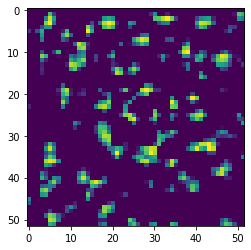

In [9]:
plt.imshow(roi[0], vmin =0, vmax=1)

In [10]:
res = FastDensityClustering.density_clustering(roi[8],  gravity_size=2, gravity_type="disk")
res1 = FastDensityClustering.density_clustering(roi[9],  gravity_size=2, gravity_type="disk")

(10, 2)
(6, 2)
(10, 2)
(17, 2)
(13, 2)
(14, 2)
(8, 2)
(14, 2)
(6, 2)
(10, 2)
(6, 2)
(1, 2)
(2, 2)
(8, 2)
(6, 2)
(3, 2)
(8, 2)
(3, 2)
(1, 2)
(3, 2)
(18, 2)
(14, 2)
(15, 2)
(13, 2)
(6, 2)
(6, 2)
(12, 2)
(9, 2)
(9, 2)
(4, 2)
(10, 2)
(13, 2)
(17, 2)
(8, 2)
(11, 2)
(8, 2)
(7, 2)
(14, 2)
(18, 2)
(9, 2)
(22, 2)
(9, 2)
(4, 2)
(17, 2)
(3, 2)
(4, 2)
(5, 2)
(4, 2)
(9, 2)
(1, 2)
(8, 2)
(13, 2)
(7, 2)
(16, 2)
(6, 2)
(3, 2)
(3, 2)
(3, 2)
(9, 2)
(4, 2)
(17, 2)
(7, 2)
(17, 2)
(8, 2)
(13, 2)
(3, 2)
(4, 2)
(2, 2)
(16, 2)
(7, 2)
(9, 2)
(27, 2)
(8, 2)
(5, 2)
(8, 2)
(17, 2)
(6, 2)
(9, 2)
(4, 2)
(5, 2)
(1, 2)
(2, 2)
(5, 2)
(9, 2)
(3, 2)
(10, 2)
(13, 2)
(15, 2)
(1, 2)
(18, 2)
(9, 2)
(1, 2)
(6, 2)
(5, 2)
(7, 2)
(7, 2)
(14, 2)
(10, 2)
(2, 2)
(9, 2)
(15, 2)
(9, 2)
(9, 2)
(2, 2)
(7, 2)
(13, 2)
(15, 2)
(20, 2)
(8, 2)
(18, 2)
(4, 2)
(7, 2)
(5, 2)
(15, 2)
(4, 2)
(14, 2)
(4, 2)
(1, 2)
(8, 2)
(7, 2)
(20, 2)
(7, 2)
(9, 2)
(9, 2)
(10, 2)
(4, 2)
(3, 2)
(7, 2)
(19, 2)
(16, 2)
(9, 2)
(2, 2)
(5, 2)
(12, 2)
(3, 2)
(3, 2)


In [11]:
assert np.all(np.array(res[3]>0,np.int32)-np.array(roi[8],dtype=np.int32)) == 0

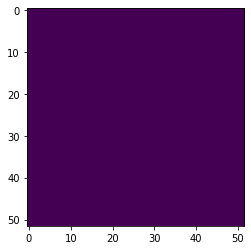

In [12]:
plt.imshow(res[3]<0)

In [13]:
np.max(res[2])

67.0

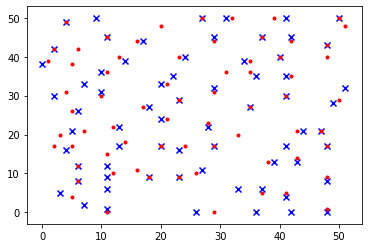

In [14]:
fig, ax = plt.subplots(1)
ax.scatter(res[0],res[1],c="b", marker="x")
ax.scatter(res1[0],res1[1],c="r",marker=".")

In [15]:
import matplotlib
import matplotlib.animation
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

mapp, labels_raw, coords = FastDensityClustering.mappings(roi, search_window_size=10, frames=10)

.(15, 2)
(12, 2)
(5, 2)
(13, 2)
(14, 2)
(6, 2)
(3, 2)
(5, 2)
(1, 2)
(7, 2)
(12, 2)
(2, 2)
(13, 2)
(9, 2)
(1, 2)
(6, 2)
(3, 2)
(4, 2)
(9, 2)
(20, 2)
(16, 2)
(2, 2)
(4, 2)
(4, 2)
(9, 2)
(7, 2)
(3, 2)
(2, 2)
(3, 2)
(15, 2)
(11, 2)
(3, 2)
(12, 2)
(3, 2)
(2, 2)
(6, 2)
(4, 2)
(5, 2)
(1, 2)
(1, 2)
(9, 2)
(6, 2)
(11, 2)
(3, 2)
(6, 2)
(3, 2)
(19, 2)
(9, 2)
(12, 2)
(13, 2)
(7, 2)
(9, 2)
(11, 2)
(24, 2)
(2, 2)
(11, 2)
(7, 2)
(16, 2)
(10, 2)
(18, 2)
(18, 2)
(9, 2)
(3, 2)
(5, 2)
(4, 2)
(1, 2)
(2, 2)
(2, 2)
(6, 2)
(15, 2)
(11, 2)
(6, 2)
(7, 2)
(2, 2)
(2, 2)
(7, 2)
(14, 2)
(14, 2)
(12, 2)
(14, 2)
(10, 2)
(7, 2)
(3, 2)
(14, 2)
(13, 2)
(11, 2)
(1, 2)
(1, 2)
(11, 2)
(2, 2)
(2, 2)
(7, 2)
(1, 2)
(22, 2)
(16, 2)
(4, 2)
(7, 2)
(1, 2)
(9, 2)
(6, 2)
(5, 2)
(12, 2)
(20, 2)
(3, 2)
(5, 2)
(3, 2)
(12, 2)
(4, 2)
(3, 2)
(17, 2)
(4, 2)
(10, 2)
(12, 2)
(4, 2)
(8, 2)
(1, 2)
(18, 2)
(6, 2)
(15, 2)
(5, 2)
(16, 2)
(11, 2)
(7, 2)
(32, 2)
(1, 2)
(10, 2)
(2, 2)
(4, 2)
(10, 2)
(2, 2)
(17, 2)
(21, 2)
(2, 2)
(6, 2)
(2, 2)
(4, 

.(10, 2)
(6, 2)
(10, 2)
(17, 2)
(13, 2)
(14, 2)
(8, 2)
(14, 2)
(6, 2)
(10, 2)
(6, 2)
(1, 2)
(2, 2)
(8, 2)
(6, 2)
(3, 2)
(8, 2)
(3, 2)
(1, 2)
(3, 2)
(18, 2)
(14, 2)
(15, 2)
(13, 2)
(6, 2)
(6, 2)
(12, 2)
(9, 2)
(9, 2)
(4, 2)
(10, 2)
(13, 2)
(17, 2)
(8, 2)
(11, 2)
(8, 2)
(7, 2)
(14, 2)
(18, 2)
(9, 2)
(22, 2)
(9, 2)
(4, 2)
(17, 2)
(3, 2)
(4, 2)
(5, 2)
(4, 2)
(9, 2)
(1, 2)
(8, 2)
(13, 2)
(7, 2)
(16, 2)
(6, 2)
(3, 2)
(3, 2)
(3, 2)
(9, 2)
(4, 2)
(17, 2)
(7, 2)
(17, 2)
(8, 2)
(13, 2)
(3, 2)
(4, 2)
(2, 2)
(16, 2)
(7, 2)
(9, 2)
(27, 2)
(8, 2)
(5, 2)
(8, 2)
(17, 2)
(6, 2)
(9, 2)
(4, 2)
(5, 2)
(1, 2)
(2, 2)
(5, 2)
(9, 2)
(3, 2)
(10, 2)
(13, 2)
(15, 2)
(1, 2)
(18, 2)
(9, 2)
(1, 2)
(6, 2)
(5, 2)
(7, 2)
(7, 2)
(14, 2)
(10, 2)
(2, 2)
(9, 2)
(15, 2)
(9, 2)
(9, 2)
(2, 2)
(7, 2)
(13, 2)
(15, 2)
(20, 2)
(8, 2)
(18, 2)
(4, 2)
(7, 2)
(5, 2)
(15, 2)
(4, 2)
(14, 2)
(4, 2)
(1, 2)
(8, 2)
(7, 2)
(20, 2)
(7, 2)
(9, 2)
(9, 2)
(10, 2)
(4, 2)
(3, 2)
(7, 2)
(19, 2)
(16, 2)
(9, 2)
(2, 2)
(5, 2)
(12, 2)
(3, 2)
(3, 2)


In [42]:
labels = FastDensityClustering.heuristic_tracking(mapp, np.array(labels_raw,dtype=np.int32))

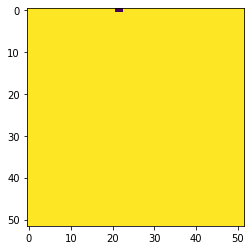

In [43]:
plt.imshow(np.array(labels[3]>0,dtype=np.int32)-np.array(labels_raw[3]>0,dtype=np.int32))

In [44]:
labels[labels==0] = np.nan

In [48]:
%%capture
from matplotlib import cm

vals = np.linspace(0,1,512)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
fig, ax = plt.subplots(1,2, figsize=(10,10))
im = ax[0].imshow(labels[1], cmap = cmap, vmin=0,vmax=1)
im1 = ax[1].imshow(roi[1],vmin=0,vmax=1)
ani = matplotlib.animation.FuncAnimation(fig, lambda i: [im.set_array(labels[i]==1),im1.set_array(roi[i])], 
                                         frames=len(labels)-1).to_jshtml()

In [49]:
open("tracking.html","w").write(ani)

150609

In [51]:
HTML(ani)

In [ ]:
if combined_shape_similar() -> increase claim

In [ ]:
def closest_label(arr):
    coords = np.where(arr>0)
    if len(coords[0]) == 0:
        return None, [0,0]
    coords = np.array(coords)
    coords1 = coords-len(arr)//2
    idx = np.argmin(np.square(coords1[0])+np.square(coords1[1]))
    pos = coords[:,idx]
    
    return arr[pos[0],pos[1]], pos

In [ ]:
# Test
closest_label(np.array([[0,0,0],
                        [0,0,0],
                        [0,42,10]]))

In [47]:
def assign_closest(coords_t0, mat_t1, search_window_size = 5):
    """ Computes mapping between labels based on coordinates (coords_t0) and closest pixels (mat_t1)"""
    search_window_size = (search_window_size//2)*2
    indent = search_window_size//2
    mat_t1 = np.pad(mat_t1,indent*2, "constant")
    mapping = {}
    mapping_operation = {}
    
    i = 0
    for y, x in coords_t0:
        snippet = mat_t1[indent+y : indent+y+search_window_size+1, indent+x : indent+x+search_window_size+1]
        label, pos = closest_label(snippet)  
        if type(label) == type(None):
            i += 1
            continue
        #TODO: check for merge

        pos[0] += y
        pos[1] += x

        mapping[i+1] = label
        mapping_operation[i] = "moved"
        mat_t1[pos[0],pos[1]] = 0
        i += 1
        
    return mapping, mapping_operation

In [ ]:
#Test
coords_t0 = np.array([[5,8],[5,8]]).T
mat_t1 = np.zeros((10,10))
mat_t1[7,7] = 41
mat_t1[5,3] = 40
mat_t2 = np.zeros((10,10))
mat_t2[7,7] = 41
mat_t2[5,3] = 40
#print_points_and_background(mat_t1, coords_t0[0],coords_t0[1])
test_res = assign_closest(coords_t0, mat_t1, search_window_size = 5)
assert test_res[0][1] == 40
assert test_res[0][2] == 41

In [ ]:
#Perform clustering
frame = 0
gravity_type = "disk"
gravity_size = 4

res = FastDensityClustering.density_clustering(roi[frame], gravity_size=gravity_size, gravity_type=gravity_type)
res1 = FastDensityClustering.density_clustering(roi[frame+1], gravity_size=gravity_size, gravity_type=gravity_type)

#Prepare data
coords_t0 = np.array([res[0][1:],res[1][1:]]).T
coords_t1 = np.array([res1[0][1:],res1[1][1:]]).T


mat_t1 = np.zeros(res[2].shape, dtype=np.uint32)
for i, x in enumerate(coords_t1):
    mat_t1[x[0],x[1]] = i+1
    


In [ ]:
plt.imshow(mat_t1>0)

In [ ]:
coords_t0[0,0]

In [ ]:
mapping, _ = assign_closest(coords_t0, mat_t1, search_window_size = 10)

In [ ]:
print_points_and_background(res[3],coords_t0[:,1],coords_t0[:,0])

In [ ]:
n = 1
print_points_and_background(res[3]==n,coords_t0[n-1,1],coords_t0[n-1,0])

In [ ]:
mapping = assign_closest(coords_t0, mat_t1)[0]

In [ ]:
len(mapping.keys())

In [ ]:
def print_clusters(mapping, labels, labels1, cluster_id):
    if not cluster_id in mapping:
        print("Cluster not in mapping")
        return
    fig, ax = plt.subplots(2)
    ax[0].imshow(labels==cluster_id)
    ax[1].imshow(labels1==mapping[cluster_id])
    plt.show()

In [ ]:
for x in range(4):
    print_clusters(mapping,res[3],res1[3],x)

In [48]:
def print_points_and_background(img, x,y, point_size=10, marker ="."):
    """ Prints samled points in front of image
    Args:
        img: Image as numpy array
        x: Vector of x positions
        y: Vector of y positions

    """
    fig, ax = plt.subplots(1, figsize=(12,10))

    ax.set_xlim((0, img.shape[1]))
    ax.set_ylim((img.shape[0], 0))
    ax.imshow(img)
    ax.scatter(x,y, s=point_size,c="red",marker=marker)

In [49]:
def mappings(roi, gravity_size=2, gravity_type="disk", frames = 100, search_window_size=5):
    mappings_out = []
    labels = []
    for frame in range(frames):
        print(".",end="")
        #Perform clustering
        res = FastDensityClustering.density_clustering(roi[frame], gravity_size=gravity_size, gravity_type=gravity_type)
        res1 = FastDensityClustering.density_clustering(roi[frame+1], gravity_size=gravity_size, gravity_type=gravity_type)

        #Prepare data
        coords_t0 = np.array([res[0][1:],res[1][1:]]).T
        coords_t1 = np.array([res1[0][1:],res1[1][1:]]).T


        mat_t1 = np.zeros(res[2].shape, dtype=np.uint32)
        for i, x in enumerate(coords_t1):
            mat_t1[x[0],x[1]] = i+1

        #Retrieve mappings
        mapping, _ = assign_closest(coords_t0, mat_t1, search_window_size=search_window_size)
        mappings_out.append(mapping)
        labels.append(res[3])
        
    return mappings_out, np.array(labels)

In [50]:
mapp, labels = mappings(roi, frames = 20)

.

NameError: name 'closest_label' is not defined

In [ ]:
def rek_track(mapp, slice, source_id, target_id, labels, out):
    if not source_id in mapp[slice]:
        return out, mapp, target_id
    if slice >= len(mapp)-1:
        return out, mapp, target_id
    out[slice][labels[slice] == source_id] = target_id#Paint here
    out, mapp, target_id = rek_track(mapp, slice+1, mapp[slice][source_id], target_id, labels, out)
    del(mapp[slice][source_id])
    return out, mapp, target_id

def process_layer(mapp, layer, target_id, labels, out):
    for k in mapp[layer].keys():
        target_id += 1
        out, mapp, target_id = rek_track(mapp,layer+1,k,target_id, labels, out)
    return out, mapp, target_id

def process_layers(mapp, labels):
    current_map = copy.deepcopy(mapp)
    target_id = 0
    out = np.zeros(labels.shape)
    for layer_id in range(len(current_map)-1):
        out, current_map, target_id = process_layer(current_map,layer_id,target_id, labels, out)
    return out

In [ ]:
out, _, _ = FastDensityClustering.process_layer(copy.deepcopy(mapp),0,0, labels, np.zeros(labels.shape))

In [ ]:
x = process_layers(mapp, labels)

In [ ]:
#x[x[:,:,:]<100] = 0

In [ ]:
#x[x[:,:,:]>200] = 0

In [ ]:
plt.imshow(x[80])
plt.colorbar()

In [ ]:
%%capture
import matplotlib
import matplotlib.animation
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))


fig, ax = plt.subplots(1, figsize=(10,10))
im = ax.imshow(x[9], cmap = cmap, vmin=0,vmax=5000)
ani = matplotlib.animation.FuncAnimation(fig, lambda i: [im.set_array(x[i])], frames=len(x)).to_jshtml()

In [ ]:
HTML(ani)